## Analysis of tomographic images of brain hemorrhages and their recognition through machine learning models


In [2]:
! pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp311-cp311-macosx_10_9_x86_64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp311-cp311-macosx_10_9_x86_64.whl (18.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.17 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.16 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.


In [2]:
# from google.colab import drive
import pandas as pd
from IPython.display import Image, display
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as pilimg, ImageOps
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [8]:
! pip install segmentation-models

In [4]:
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
from segmentation_models import Unet
from segmentation_models.metrics import iou_score

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
demog = pd.read_csv('/content/drive/My Drive/Bioinformatika proekt/patient_demographics.csv')

In [ ]:
demog.head()

Patient Number  Age\n(years)  Gender  Intraventricular  Intraparenchymal  \
0              49     35.000000    Male               NaN               1.0   
1              50      0.583333  Female               NaN               1.0   
2              51      5.000000    Male               NaN               1.0   
3              52      8.000000    Male               NaN               NaN   
4              53     44.000000    Male               NaN               1.0   

   Subarachnoid  Epidural  Subdural  Fracture (Yes/No)  \
0           NaN       1.0       NaN                1.0   
1           NaN       NaN       NaN                1.0   
2           NaN       NaN       1.0                1.0   
3           NaN       1.0       NaN                1.0   
4           NaN       1.0       NaN                1.0   

                   Condition on file Note  
0  Intracranial HGE+ Extradural HGE   NaN  
1                      Subdural HGE   NaN  
2                     Extadural HGE   NaN  
3                     Extadural HGE   NaN  
4  Intracranial HGE+ Extradural HGE   NaN

In [ ]:
demog.rename(columns={'Patient Number': 'PatientNumber'}, inplace=True)

In [ ]:
diag = pd.read_csv('/content/drive/My Drive/Bioinformatika proekt/hemorrhage_diagnosis.csv')

In [ ]:
diag.head()

PatientNumber  SliceNumber  Intraventricular  Intraparenchymal  \
0             49            1                 0                 0   
1             49            2                 0                 0   
2             49            3                 0                 0   
3             49            4                 0                 0   
4             49            5                 0                 0   

   Subarachnoid  Epidural  Subdural  No_Hemorrhage  Fracture_Yes_No  
0             0         0         0              1                0  
1             0         0         0              1                0  
2             0         0         0              1                0  
3             0         0         0              1                0  
4             0         0         0              1                0

In [ ]:
patient_data = pd.merge(demog, diag, on='PatientNumber')

In [ ]:
patient_data.head()

PatientNumber  Age\n(years) Gender  Intraventricular_x  Intraparenchymal_x  \
0             49          35.0   Male                 NaN                 1.0   
1             49          35.0   Male                 NaN                 1.0   
2             49          35.0   Male                 NaN                 1.0   
3             49          35.0   Male                 NaN                 1.0   
4             49          35.0   Male                 NaN                 1.0   

   Subarachnoid_x  Epidural_x  Subdural_x  Fracture (Yes/No)  \
0             NaN         1.0         NaN                1.0   
1             NaN         1.0         NaN                1.0   
2             NaN         1.0         NaN                1.0   
3             NaN         1.0         NaN                1.0   
4             NaN         1.0         NaN                1.0   

                   Condition on file Note  SliceNumber  Intraventricular_y  \
0  Intracranial HGE+ Extradural HGE   NaN            1                   0   
1  Intracranial HGE+ Extradural HGE   NaN            2                   0   
2  Intracranial HGE+ Extradural HGE   NaN            3                   0   
3  Intracranial HGE+ Extradural HGE   NaN            4                   0   
4  Intracranial HGE+ Extradural HGE   NaN            5                   0   

   Intraparenchymal_y  Subarachnoid_y  Epidural_y  Subdural_y  No_Hemorrhage  \
0                   0               0           0           0              1   
1                   0               0           0           0              1   
2                   0               0           0           0              1   
3                   0               0           0           0              1   
4                   0               0           0           0              1   

   Fracture_Yes_No  
0                0  
1                0  
2                0  
3                0  
4                0

In [ ]:
row_to_drop = (patient_data['PatientNumber'] == 84) & (patient_data['SliceNumber'] == 36)

In [ ]:
condition = patient_data['PatientNumber'] == 84
slices = patient_data.loc[condition]

In [ ]:
patient_data = patient_data.drop(patient_data[row_to_drop].index)

In [ ]:
patient_data = patient_data.reset_index(drop=True)

In [ ]:
patient_data['Has_Hemorrhage'] = patient_data['No_Hemorrhage'].apply(lambda x: 0 if x == 1 else 1)
patient_data = patient_data.drop('No_Hemorrhage', axis=1)

In [ ]:
patient_data.fillna(0, inplace=True)

In [ ]:
def convert_toarray(path,to_rgb):
  img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  if(to_rgb):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 128))
  img = img/255.0
  img = img.astype(np.float32)
  return img

In [ ]:
def imagePathBone(row):
  patient_folder = f"{int(row['PatientNumber']):03d}"
  slice_file = f"{row['SliceNumber']}.jpg"
  bone_path = os.path.join('/content/drive/My Drive/Bioinformatika proekt/Patients_CT', patient_folder, 'bone', slice_file)
  return convert_toarray(bone_path,False)

def imagePathBrain(row):
  patient_folder = f"{int(row['PatientNumber']):03d}"
  slice_file = f"{row['SliceNumber']}.jpg"
  mask_file = f"{row['SliceNumber']}_HGE_Seg.jpg"
  base_path = '/content/drive/My Drive/Bioinformatika proekt/Patients_CT/' + str(patient_folder) + '/brain/'
  if(os.path.exists(base_path+mask_file)):
    return convert_toarray(base_path+slice_file,True), convert_toarray(base_path+mask_file,False)
  else:
    return convert_toarray(base_path+slice_file,True), np.zeros((128, 128), dtype=np.uint8)

In [ ]:
patient_data['ImagePathBone'] = patient_data.apply(imagePathBone, axis=1)
patient_data[['ImagePathBrain','ImagePathBrainMask']] = patient_data.apply(imagePathBrain, axis=1, result_type='expand')

In [ ]:
patient_data['Has_Hemorrhage'].value_counts()

Has_Hemorrhage
0    2182
1     318
Name: count, dtype: int64

In [ ]:
patient_data.head()

PatientNumber  Age\n(years) Gender  Intraventricular_x  Intraparenchymal_x  \
0             49          35.0   Male                 0.0                 1.0   
1             49          35.0   Male                 0.0                 1.0   
2             49          35.0   Male                 0.0                 1.0   
3             49          35.0   Male                 0.0                 1.0   
4             49          35.0   Male                 0.0                 1.0   

   Subarachnoid_x  Epidural_x  Subdural_x  Fracture (Yes/No)  \
0             0.0         1.0         0.0                1.0   
1             0.0         1.0         0.0                1.0   
2             0.0         1.0         0.0                1.0   
3             0.0         1.0         0.0                1.0   
4             0.0         1.0         0.0                1.0   

                   Condition on file  ... Intraventricular_y  \
0  Intracranial HGE+ Extradural HGE   ...                  0   
1  Intracranial HGE+ Extradural HGE   ...                  0   
2  Intracranial HGE+ Extradural HGE   ...                  0   
3  Intracranial HGE+ Extradural HGE   ...                  0   
4  Intracranial HGE+ Extradural HGE   ...                  0   

   Intraparenchymal_y  Subarachnoid_y  Epidural_y  Subdural_y  \
0                   0               0           0           0   
1                   0               0           0           0   
2                   0               0           0           0   
3                   0               0           0           0   
4                   0               0           0           0   

   Fracture_Yes_No  Has_Hemorrhage  \
0                0               0   
1                0               0   
2                0               0   
3                0               0   
4                0               0   

                                       ImagePathBone  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                      ImagePathBrain  \
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   

                                  ImagePathBrainMask  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[5 rows x 22 columns]

In [ ]:
patient_data.to_csv('patient_data3.csv.gz', compression='gzip', index=False)

In [ ]:
patient_data.to_pickle('/content/drive/My Drive/patient_data.pkl')

NameError: name 'patient_data' is not defined

In [ ]:
!ls

drive  patient_data3.csv.gz  sample_data


In [ ]:
!mv 'patient_data3.csv.gz' '/content/drive/My Drive/'

In [ ]:
dataset = pd.read_csv('/content/drive/My Drive/patient_data3.csv.gz', compression='gzip')
dataset.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/patient_data3.csv.gz'

In [6]:
patient_data = pd.read_pickle('./patient_data.pkl')

In [8]:
patient_data.head()

PatientNumber  Age\n(years) Gender  Intraventricular_x  Intraparenchymal_x  \
0             49          35.0   Male                 0.0                 1.0   
1             49          35.0   Male                 0.0                 1.0   
2             49          35.0   Male                 0.0                 1.0   
3             49          35.0   Male                 0.0                 1.0   
4             49          35.0   Male                 0.0                 1.0   

   Subarachnoid_x  Epidural_x  Subdural_x  Fracture (Yes/No)  \
0             0.0         1.0         0.0                1.0   
1             0.0         1.0         0.0                1.0   
2             0.0         1.0         0.0                1.0   
3             0.0         1.0         0.0                1.0   
4             0.0         1.0         0.0                1.0   

                   Condition on file  ... Intraventricular_y  \
0  Intracranial HGE+ Extradural HGE   ...                  0   
1  Intracranial HGE+ Extradural HGE   ...                  0   
2  Intracranial HGE+ Extradural HGE   ...                  0   
3  Intracranial HGE+ Extradural HGE   ...                  0   
4  Intracranial HGE+ Extradural HGE   ...                  0   

   Intraparenchymal_y  Subarachnoid_y  Epidural_y  Subdural_y  \
0                   0               0           0           0   
1                   0               0           0           0   
2                   0               0           0           0   
3                   0               0           0           0   
4                   0               0           0           0   

   Fracture_Yes_No  Has_Hemorrhage  \
0                0               0   
1                0               0   
2                0               0   
3                0               0   
4                0               0   

                                       ImagePathBone  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...   

                                      ImagePathBrain  \
0  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
1  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
2  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
3  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   
4  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...   

                                  ImagePathBrainMask  
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  
4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[5 rows x 22 columns]

In [ ]:
import ast

**Preview images**

In [ ]:
image = patient_data.loc[13]['ImagePathBrain']
mask = patient_data.loc[13]['ImagePathBrainMask']
bones = patient_data.loc[13]['ImagePathBone']

In [ ]:
print(image)

[[[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]
  [0.         0.         0.        ]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.00392157 0.00392157 0.00392157]
  ...
  [0.00392157 0.00392157 0.00392157]
  [0.00392157 0.00392157 0.00392157]
  [0.         0.         0.        ]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


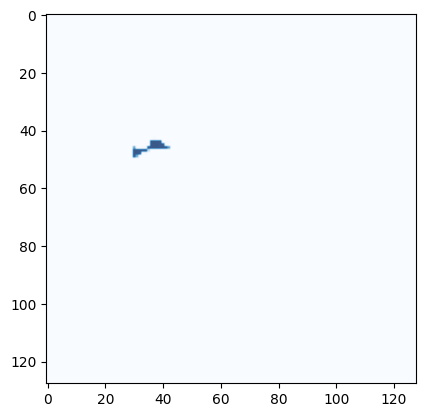

In [ ]:
plt.imshow(mask, cmap='Blues', alpha=0.8)

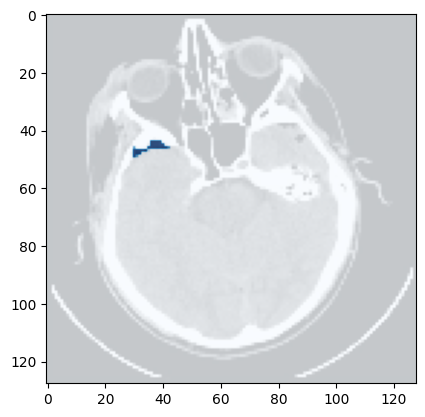

In [ ]:
plt.imshow(image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.8)

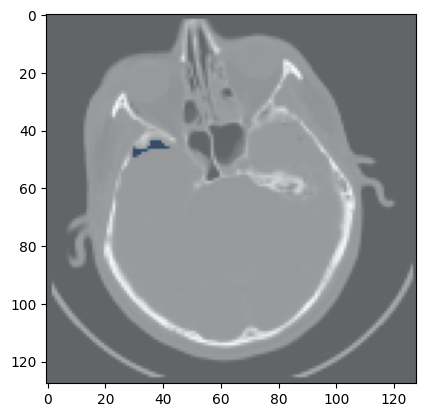

In [ ]:
plt.imshow(bones, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.4)

**TODO: Add augmentation**

<Figure size 640x480 with 0 Axes>

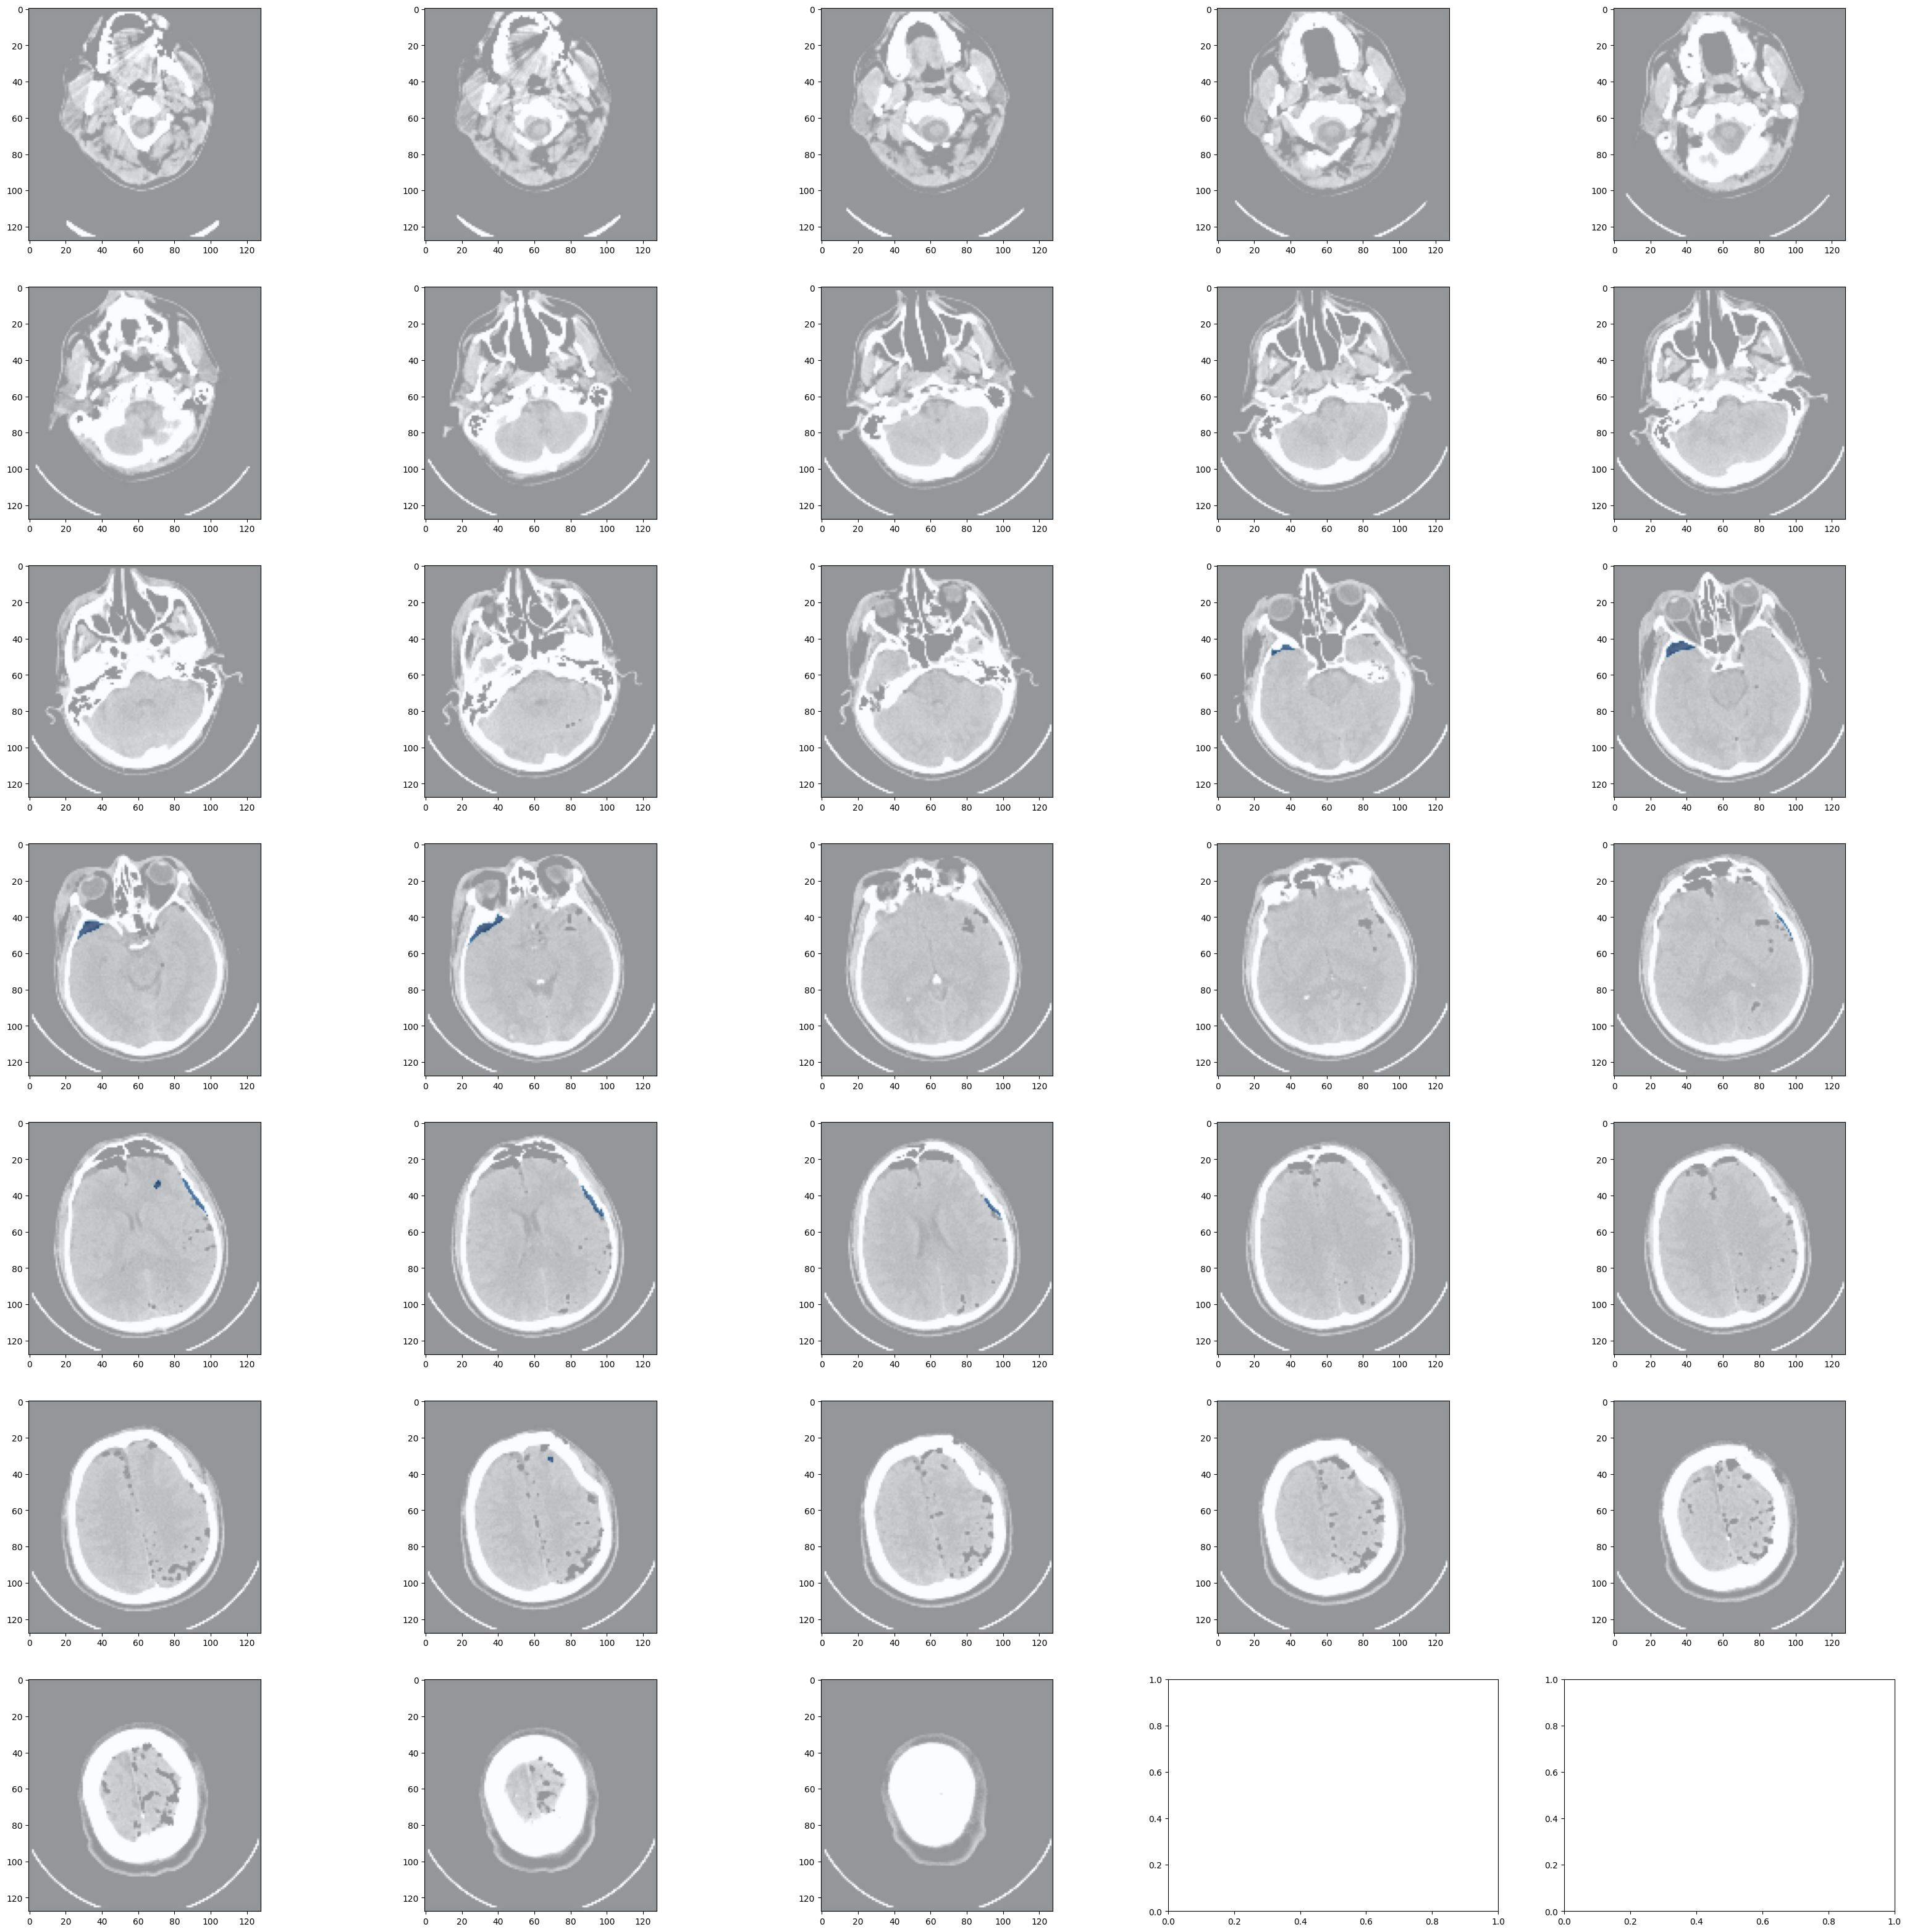

In [ ]:
def show_slices(items,type):
  plt.figure()

  f, axarr = plt.subplots((len(items)//5)+1,5,figsize = (40,40))
  for i in range(len(items)):
    axarr[i//5][i%5].imshow(items.loc[i][type],cmap='gray')
    axarr[i//5][i%5].imshow(items.loc[i]['ImagePathBrainMask'],cmap='Blues',alpha=0.6)

patient = patient_data[patient_data['PatientNumber'] == 49].sort_values(by=["SliceNumber"],ascending=True)
show_slices(patient,'ImagePathBrain')

**Train test split**

In [7]:
df_train_all, df_test = train_test_split(patient_data, test_size=0.20)
df_train, df_val = train_test_split(df_train_all, test_size=0.15)

# df_train = patient_data[:30]
# df_val = patient_data[30:50]

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)



(1700, 22)
(300, 22)
(500, 22)


In [8]:
from sklearn.utils import shuffle

In [9]:
df_train = shuffle(df_train)
df_val = shuffle(df_val)


In [14]:
print(len(df_val))

300


In [17]:
X_train = np.array([val.astype(np.float32) for val in df_train['ImagePathBrain']]).astype(np.float32)
Y_train = np.array([val.astype(np.float32) for val in df_train['ImagePathBrainMask']])
Y_train = np.expand_dims(Y_train,axis=-1).astype(np.float32)

In [18]:
X_val = np.array([val.astype(np.float32) for val in df_val['ImagePathBrain']]).astype(np.float32)
Y_val = np.expand_dims([val.astype(np.float32) for val in df_val['ImagePathBrainMask']],axis=-1).astype(np.float32)
# Y_val = (Y_train,).astype(np.float32)

In [19]:
from segmentation_models import get_preprocessing
# import tf_keras

BACKBONE = "densenet121"
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(128, 128, 3),
             #freeze_encoder=False,
             classes=1,
             encoder_weights='imagenet',
             activation='sigmoid')


In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_score])

In [13]:
!pip install albumentations

^C
Traceback (most recent call last):
  File "/Users/aleks/Desktop/bioinformatika/venv/bin/pip", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/pip/_internal/cli/main.py", line 78, in main
    command = create_command(cmd_name, isolated=("--isolated" in cmd_args))
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/pip/_internal/commands/__init__.py", line 114, in create_command
    module = importlib.import_module(module_path)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1206, in _gcd_import
  Fil

In [14]:
import albumentations as A

In [96]:
transform = A.Compose([
    A.Rotate(limit=(-15, 15), p=1),
    A.OneOf([
        A.augmentations.geometric.transforms.Affine(
            shear={'x': (-10, 10), 'y': (-10, 10)}, p=0.5),
        A.augmentations.geometric.transforms.Affine(scale=(0.9, 1.1), p=0.5)
    ], p=0.5),
    A.augmentations.geometric.transforms.Affine(
        translate_px={'x': (-10, 10), 'y': (-10, 10)}, p=0.8),
    # A.ColorJitter(brightness=(0.9, 1.1), p=0.2),
    A.CLAHE(clip_limit=1.1, p=0.2),
    # A.GaussNoise(var_limit=20.0, p=0.05)
],
    additional_targets={'image0': 'image'})

In [102]:
X_train_aug = []
Y_train_aug = []
X_val_aug = []
Y_val_aug = []
for x_tr, y_tr in zip(X_train, Y_train):
  X_train_aug.append(x_tr.astype(np.float32))
  Y_train_aug.append(y_tr.astype(np.float32))
  aug_image_train = transform(image=x_tr.astype(np.float32),image0=y_tr.astype(np.float32))
  X_train_aug.append(aug_image_train['image'].astype(np.float32))
  Y_train_aug.append(aug_image_train['image0'].astype(np.float32))
for x_val, y_val in zip(X_val, Y_val):
  X_val_aug.append(x_val.astype(np.float32))
  Y_val_aug.append(y_val.astype(np.float32))
  aug_image_val = transform(image=x_val.astype(np.float32),image0=y_val.astype(np.float32))
  X_val_aug.append(aug_image_val['image'].astype(np.float32))
  Y_val_aug.append(aug_image_val['image0'].astype(np.float32))

In [99]:
X_train_aug = np.array([val.astype(np.float32) for val in X_train_aug]).astype(np.float32)
X_val_aug = np.array([val.astype(np.float32) for val in X_val_aug]).astype(np.float32)
Y_train_aug = np.array([val.astype(np.float32) for val in Y_train_aug]).astype(np.float32)
Y_val_aug = np.array([val.astype(np.float32) for val in Y_val_aug]).astype(np.float32)

In [107]:
X_train_aug, Y_train_aug = shuffle(X_train_aug, Y_train_aug, random_state=0)
X_val_aug, Y_val_aug = shuffle(X_val_aug, Y_val_aug, random_state=0)


: 

In [88]:
aug = X_train_aug[24]
aug_m = Y_train_aug[24]
plt.imshow(aug, cmap='gray', alpha=1)
# print(aug)
# plt.imshow(aug_m, cmap='Reds', alpha=0.7)

Exception in Tkinter callback
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/tkinter/__init__.py", line 1948, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/tkinter/__init__.py", line 861, in callit
    func(*args)
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/matplotlib/backends/_backend_tk.py", line 271, in idle_draw
    self.draw()
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/matplotlib/backends/backend_tkagg.py", line 10, in draw
    super().draw()
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/matplotlib/backends/backend_agg.py", line 387, in draw
    self.figure.draw(self.renderer)
  File "/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/matplotlib/artist.py", line 95, in draw_wrapper
    result = draw(artist, 

: 

In [25]:
print(len(X_train_aug))
type(X_train_aug)

3400


numpy.ndarray

In [27]:
# Custom data generator
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size=16):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

train_generator = DataGenerator(X_train_aug, Y_train_aug, batch_size=24)


In [60]:
test_generator = DataGenerator(X_val_aug[:40], Y_val_aug[:40], batch_size=24)

In [29]:
filepath = "model_aug.h5"
# checkpoint = ModelCheckpoint(filepath, monitor='iou_score', verbose=1,
                            #  save_best_only=True, mode='max')

In [30]:
model.load_weights('./'+filepath)

In [58]:
history = model.fit(train_generator,
                    steps_per_epoch=len(X_train_aug) // 24,
                    epochs=10,
                    validation_data=(X_val_aug, Y_val_aug),callbacks=[checkpoint])

Epoch 1/10


AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:
!ls

drive  model_aug.h5  sample_data


In [ ]:
!ls
!mv 'model_aug.h5' '/content/drive/My Drive/'

drive  model_aug.h5  sample_data


In [61]:
predictions = model.predict(test_generator,
                                      steps=len(df_val),
                                      verbose=1)

/Users/aleks/Desktop/bioinformatika/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step    


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-25 00:59:17.267959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
print(X_train_aug[0])

In [104]:
for i in range(60,80):
    brain =X_train_aug[i]
    prediction = Y_train_aug[i]
    # prediction = predictions[33]
    plt.imshow(brain, cmap='gray', alpha=1)
    plt.imshow(prediction, cmap='Reds', alpha=0.8)
    plt.show()

In [58]:
pip freeze

absl-py==2.1.0
albucore==0.0.17
albumentations==1.4.16
annotated-types==0.7.0
appnope==0.1.4
asttokens==2.4.1
astunparse==1.6.3
cachetools==5.5.0
certifi==2024.8.30
charset-normalizer==3.3.2
comm==0.2.2
contourpy==1.3.0
cycler==0.12.1
debugpy==1.8.6
decorator==5.1.1
efficientnet==1.0.0
eval_type_backport==0.2.0
executing==2.1.0
flatbuffers==24.3.25
fonttools==4.54.1
gast==0.6.0
google-auth==2.35.0
google-auth-oauthlib==1.2.1
google-pasta==0.2.0
grpcio==1.66.1
h5py==3.11.0
idna==3.10
image-classifiers==1.0.0
imageio==2.35.1
ipykernel==6.29.5
ipython==8.27.0
jedi==0.19.1
joblib==1.4.2
jupyter_client==8.6.3
jupyter_core==5.7.2
keras==3.5.0
Keras-Applications==1.0.8
kiwisolver==1.4.7
lazy_loader==0.4
libclang==18.1.1
Markdown==3.7
markdown-it-py==3.0.0
MarkupSafe==2.1.5
matplotlib==3.9.2
matplotlib-inline==0.1.7
mdurl==0.1.2
ml-dtypes==0.3.2
namex==0.0.8
nest-asyncio==1.6.0
networkx==3.3
numpy==1.23.5
oauthlib==3.2.2
opencv-python==4.10.0.84
opencv-python-headless==4.10.0.84
opt-einsum==3.

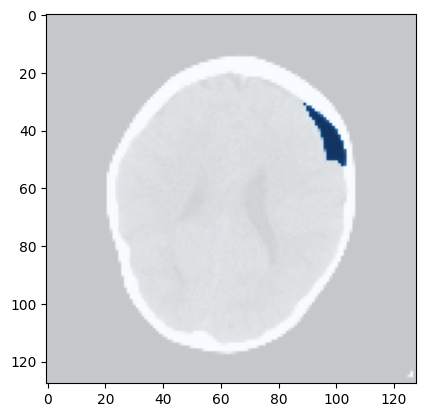

In [ ]:
brain = df_val.iloc[36]['ImagePathBrain']
original = df_val.iloc[36]['ImagePathBrainMask']
plt.imshow(brain, cmap='gray', alpha=1)
plt.imshow(original, cmap='Blues', alpha=0.8)